In [123]:
# importing basic library to wrangle and explore the data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Arima model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import pmdarima as pm

# XGBoost
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import  GridSearchCV

# Prophet - autoML
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


### Importing price series

In [2]:
# impoting the data
path = '/Users/marciobernardo/Documents/Springboard/Projects/3rd Capstone project/dados/'


df_bra_basis = pd.read_csv(path+'bra_basis.csv', index_col='date', parse_dates=['date']) 

                            

The p-value obtained from the ADF stationarity test for the Brazilian coffee basis series was low, indicating a failure to reject the null hypothesis of stationarity. We will proceed to difference the series to achieve stationarity in all the coffee time series. This step will enable us to utilize multivariate models in the basis risk analysis.

In [3]:
df_bra_basis_diff = df_bra_basis.diff().dropna()

# Saving the basis diff dataframe to a csv file
df_bra_basis_diff.to_csv(path + 'bra_basis_diff.csv', index_label='date')

Visual inspection of the differatiated series

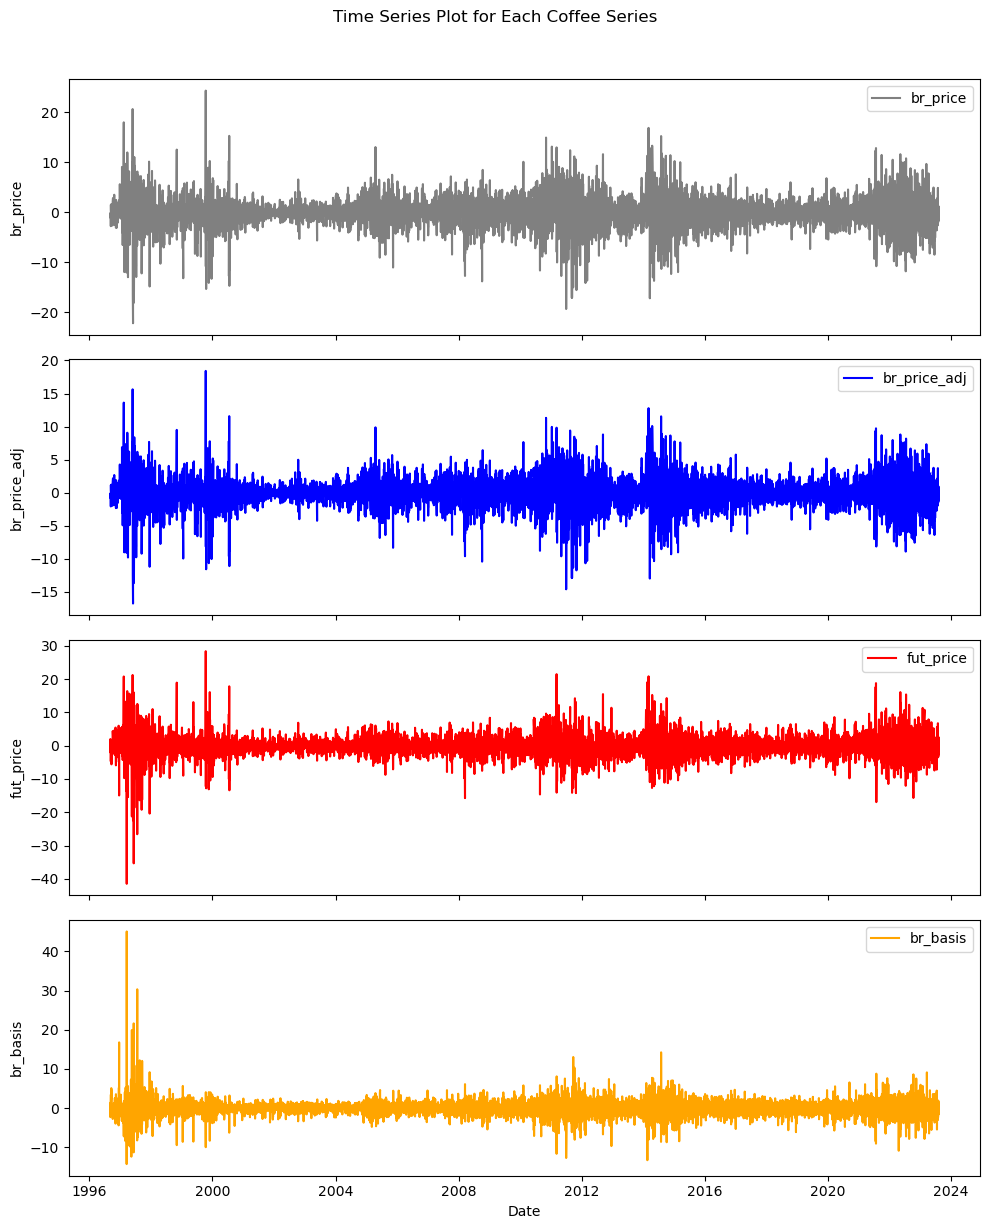

In [4]:
# Create subplots for each column
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
clr_list = ['grey', 'blue', 'red', 'orange']

# Plot each column in a separate subplot
for i, column in enumerate(df_bra_basis_diff.columns):
    axs[i].plot(df_bra_basis_diff.index, df_bra_basis_diff[column], label=column, color=clr_list[i])
    axs[i].set_ylabel(column)
    axs[i].legend()

# Set the common x-axis label and title
axs[-1].set_xlabel('Date')
plt.suptitle('Time Series Plot for Each Coffee Series', y=1.02)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [5]:
df_bra_basis_diff.describe()

br_price  br_price_adj    fut_price     br_basis
count  6514.000000   6514.000000  6514.000000  6514.000000
mean      0.008474      0.006406     0.005573     0.000834
std       3.093931      2.338975     3.367396     2.131505
min     -22.210000    -16.790498   -41.500000   -14.293563
25%      -1.360000     -1.028144    -1.487500    -0.914110
50%       0.020000      0.015120     0.000000     0.017665
75%       1.410000      1.065943     1.400000     0.945678
max      24.370000     18.423432    28.400000    45.106064

In [6]:
df_bra_basis_diff.corr()

br_price  br_price_adj  fut_price  br_basis
br_price      1.000000      1.000000   0.778723 -0.132908
br_price_adj  1.000000      1.000000   0.778723 -0.132908
fut_price     0.778723      0.778723   1.000000 -0.725300
br_basis     -0.132908     -0.132908  -0.725300  1.000000

It is interesting to note that while the coffee future price is significantly positively correlated with the spot Brazilian coffee price, its correlation with Basis risk is negative, as expected (basis = spot - future). However, the correlation level is lower, approximately 0.73, compared to the correlation between the future price and Brazilian spot coffee, which is around 0.79. This difference could be attributed to an exchange rate effect. Therefore, the exchange rate also affects the basis risk.

Calculating and saving the USD/BRL exchange rate for the period.

In [7]:
df = pd.read_csv(path + 'coffee_brazil.csv')

In [8]:
df.head()

Data  À vista R$  À vista US$
0  02/09/1996      123.09       121.15
1  03/09/1996      119.68       117.69
2  04/09/1996      119.39       117.44
3  05/09/1996      118.42       116.38
4  06/09/1996      118.09       115.98

In [9]:
# Calculating the exchange rate
df['fx'] = df['À vista R$']/df['À vista US$']
df_fx = df[['Data','fx']]

del(df)

In [10]:
df_fx.head()

Data        fx
0  02/09/1996  1.016013
1  03/09/1996  1.016909
2  04/09/1996  1.016604
3  05/09/1996  1.017529
4  06/09/1996  1.018193

In [11]:
# Creating a new dataframe with the FX rate and setting a datetime index.
df_fx.columns = ['date','fx']

df_fx.loc[:,'date'] = pd.to_datetime(df_fx['date'], format='%d/%m/%Y')

df_fx.set_index('date', inplace=True)

In [12]:
df = pd.merge(df_bra_basis, df_fx, left_index=True, right_index=True, how='inner')

In [13]:
# Saving the data frame we will be modeling
df.to_csv(path + 'df.csv', index_label='date')

In [14]:
df_fx_diff = df_fx.diff().dropna()

In [15]:
df_fx_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6705 entries, 1996-09-03 to 2023-08-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fx      6705 non-null   float64
dtypes: float64(1)
memory usage: 104.8 KB


Incorporating the Brazilian real and US dollar exchange rate to the basis series    

In [16]:
df_diff = pd.merge(df_bra_basis_diff, df_fx_diff, left_index=True, right_index=True, how='inner')

In [17]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6514 entries, 1996-09-04 to 2023-08-08
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   br_price      6514 non-null   float64
 1   br_price_adj  6514 non-null   float64
 2   fut_price     6514 non-null   float64
 3   br_basis      6514 non-null   float64
 4   fx            6514 non-null   float64
dtypes: float64(5)
memory usage: 305.3 KB


In [18]:
# Saving the data frame we will be modeling
df_diff.to_csv(path + 'df_diff.csv', index_label='date')

### ARIMA model

We will start by modeling the differentiated series on a ARIMA (2,1,1) model.

In [19]:
df_bra_basis.columns

Index(['br_price', 'br_price_adj', 'fut_price', 'br_basis'], dtype='object')

In [20]:
arma_br_model = ARIMA(df_bra_basis['br_price'], order=(2,1,1))

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
arma_br_adj_model = ARIMA(df_bra_basis['br_price_adj'], order=(2,1,1))

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
arma_fut_model = ARIMA(df_bra_basis['fut_price'], order=(2,1,1))

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
arma_br_basis_model = ARIMA(df_bra_basis['br_basis'], order=(2,1,1))


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [24]:
# Fitting the ARMA (2,1) models
results_br_model = arma_br_model.fit()
results_br_adj_model = arma_br_adj_model.fit()
results_fut_model = arma_fut_model.fit()
results_br_basis_model = arma_br_basis_model.fit()


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA models results

In [25]:
print(results_br_model.summary())

                               SARIMAX Results                                
Dep. Variable:               br_price   No. Observations:                 6515
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -16582.829
Date:                Fri, 01 Dec 2023   AIC                          33173.657
Time:                        15:10:49   BIC                          33200.784
Sample:                             0   HQIC                         33183.039
                               - 6515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4683      0.094     -4.966      0.000      -0.653      -0.284
ar.L2         -0.0703      0.008     -8.752      0.000      -0.086      -0.055
ma.L1          0.4508      0.095      4.732      0.0

In [26]:
print(results_br_adj_model.summary())

                               SARIMAX Results                                
Dep. Variable:           br_price_adj   No. Observations:                 6515
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -14760.671
Date:                Fri, 01 Dec 2023   AIC                          29529.341
Time:                        15:10:51   BIC                          29556.468
Sample:                             0   HQIC                         29538.722
                               - 6515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4682      0.094     -4.963      0.000      -0.653      -0.283
ar.L2         -0.0703      0.008     -8.752      0.000      -0.086      -0.055
ma.L1          0.4507      0.095      4.730      0.0

In [27]:
print(results_fut_model.summary())

                               SARIMAX Results                                
Dep. Variable:              fut_price   No. Observations:                 6515
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -17137.777
Date:                Fri, 01 Dec 2023   AIC                          34283.554
Time:                        15:10:54   BIC                          34310.681
Sample:                             0   HQIC                         34292.935
                               - 6515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4491      0.092     -4.883      0.000      -0.629      -0.269
ar.L2         -0.0631      0.007     -8.679      0.000      -0.077      -0.049
ma.L1          0.4350      0.093      4.696      0.0

In [28]:
print(results_br_basis_model.summary())

                               SARIMAX Results                                
Dep. Variable:               br_basis   No. Observations:                 6515
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -14093.851
Date:                Fri, 01 Dec 2023   AIC                          28195.703
Time:                        15:10:57   BIC                          28222.830
Sample:                             0   HQIC                         28205.084
                               - 6515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8715      0.006    145.089      0.000       0.860       0.883
ar.L2          0.0949      0.006     15.978      0.000       0.083       0.107
ma.L1         -0.9963      0.001   -796.050      0.0

All ARMA models have significantly different than zero paramentes. The coffee series have negative AR parameters and positive MA parameters, while the basis series have the opposit (negative AR parameters and positive MA). The variance paramentes (sigma2) is lower for the basis series, this results is reproduces in the standard deviation analises of the series. And in accordance to the expectation that basis risk is significantly lower that price risk.

Forecasting the coffee basis series with ARIMA model.

In [29]:
# In sample predictions 
br_basis_forecast = results_br_basis_model.get_prediction(start=-90)

# forecast mean
mean_br_basis_forecast = br_basis_forecast.predicted_mean

# Condifence intervals of the forecast
confidence_interbals_basis_forecast = br_basis_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_interbals_basis_forecast.loc[:,'lower br_basis']
upper_limits = confidence_interbals_basis_forecast.loc[:,'upper br_basis']

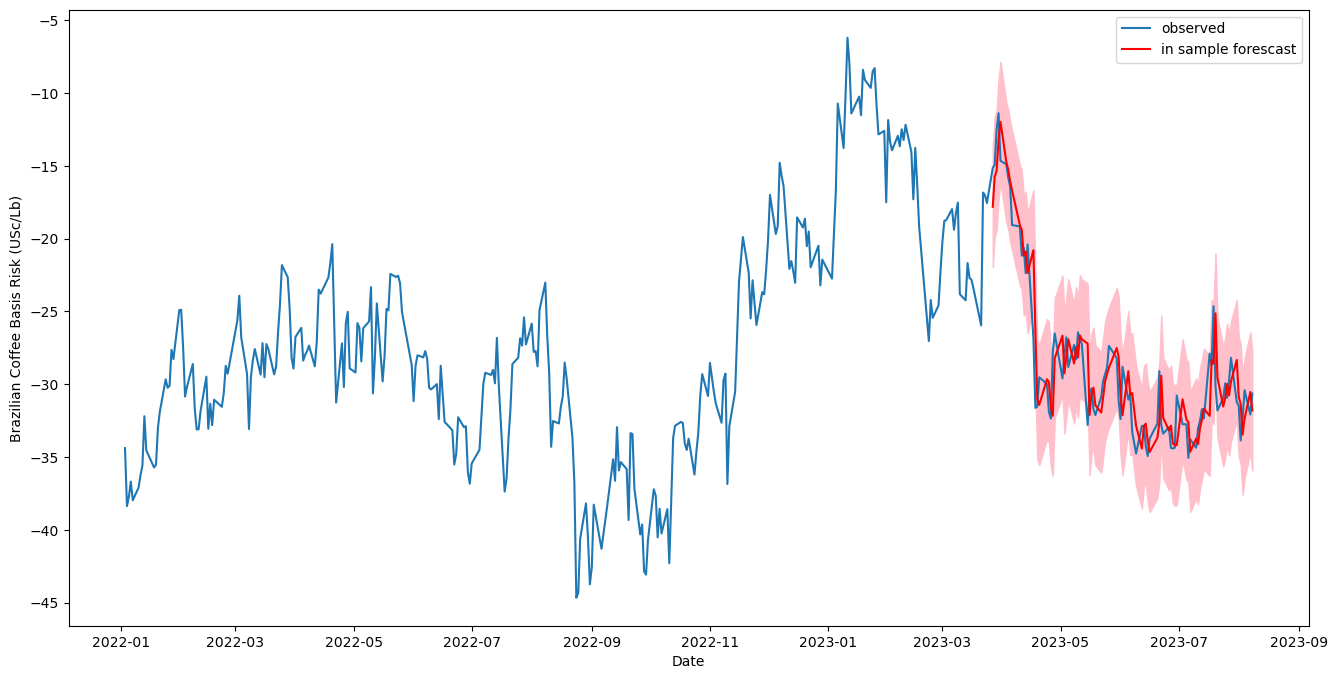

In [30]:
df_bra_basis_2022 = df_bra_basis[df_bra_basis.index.year >= 2022]

plt.figure(figsize=(16,8))

plt.plot(df_bra_basis_2022.index,
         df_bra_basis_2022['br_basis'],
         label = 'observed')
# Plot in sample prediction

plt.plot(mean_br_basis_forecast.index,
         mean_br_basis_forecast,
         color = 'red',
         label='in sample forescast')

# Plot Confidence interval
plt.fill_between(lower_limits.index, lower_limits,
		 upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Brazilian Coffee Basis Risk (USc/Lb)')
plt.legend()
plt.show();

The untrained ARIMA(2,1,1) in-sample model exhibit reasonable predictive performance, but has large confidence intervals. To generate an effective out of sample model, we will carefully consider seasonality, incorporate exogenous variables such as exchange rate, and optimize the model parameters.

Training and Testing data set

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6515 entries, 1996-09-03 to 2023-08-08
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   br_price      6515 non-null   float64
 1   br_price_adj  6515 non-null   float64
 2   fut_price     6515 non-null   float64
 3   br_basis      6515 non-null   float64
 4   fx            6515 non-null   float64
dtypes: float64(5)
memory usage: 305.4 KB


We will partition the data into training from 1996 to 2016 and testing from 2017 to 2023.

In [32]:
df.index = pd.DatetimeIndex(df.index).to_period('D')
df.index

PeriodIndex(['1996-09-03', '1996-09-04', '1996-09-05', '1996-09-06',
             '1996-09-09', '1996-09-10', '1996-09-11', '1996-09-12',
             '1996-09-13', '1996-09-16',
             ...
             '2023-07-26', '2023-07-27', '2023-07-28', '2023-07-31',
             '2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04',
             '2023-08-07', '2023-08-08'],
            dtype='period[D]', name='date', length=6515)

In [40]:
df_train = df[df.index.year <= 2016]
df_test =  df[df.index.year >= 2017]

df_diff_train = df_diff[df_diff.index.year <= 2016]
df_diff_test =  df_diff[df_diff.index.year >= 2017]

In [34]:
# saving the training and testing series

df_train.to_csv(path + 'df_train.csv', index_label='date')
df_test.to_csv(path + 'df_test.csv', index_label='date')
df_diff_train.to_csv(path + 'df_diff_train.csv', index_label='date')
df_diff_test.to_csv(path + 'df_diff_test.csv', index_label='date')

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4911 entries, 1996-09-03 to 2016-12-29
Freq: D
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   br_price      4911 non-null   float64
 1   br_price_adj  4911 non-null   float64
 2   fut_price     4911 non-null   float64
 3   br_basis      4911 non-null   float64
 4   fx            4911 non-null   float64
dtypes: float64(5)
memory usage: 230.2 KB


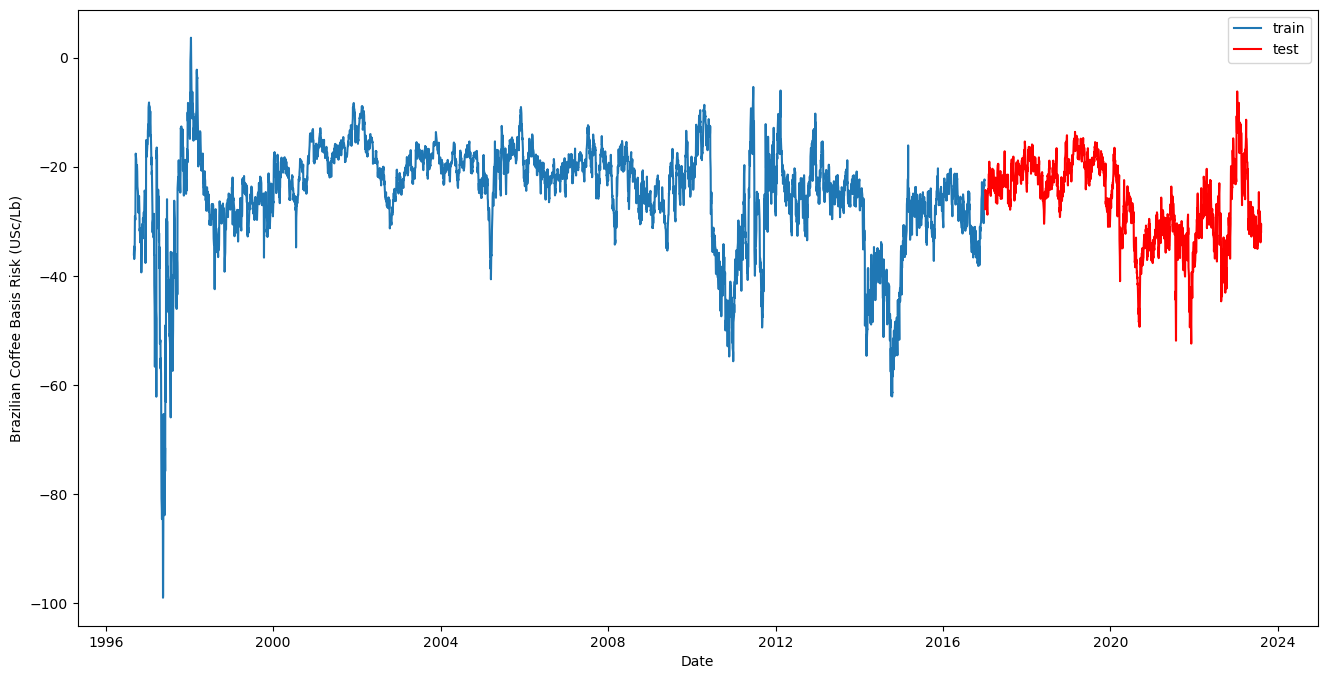

In [36]:
plt.figure(figsize=(16,8))

plt.plot(df_train.index.to_timestamp(),
        df_train['br_basis'],
         label = 'train')
# Plot in sample prediction

plt.plot(df_test.index.to_timestamp(),
         df_test['br_basis'],
         color = 'red',
         label='test')


plt.xlabel('Date')
plt.ylabel('Brazilian Coffee Basis Risk (USc/Lb)')
plt.legend()
plt.show();

### Modeling 

ACF and PACF to deduce the model order

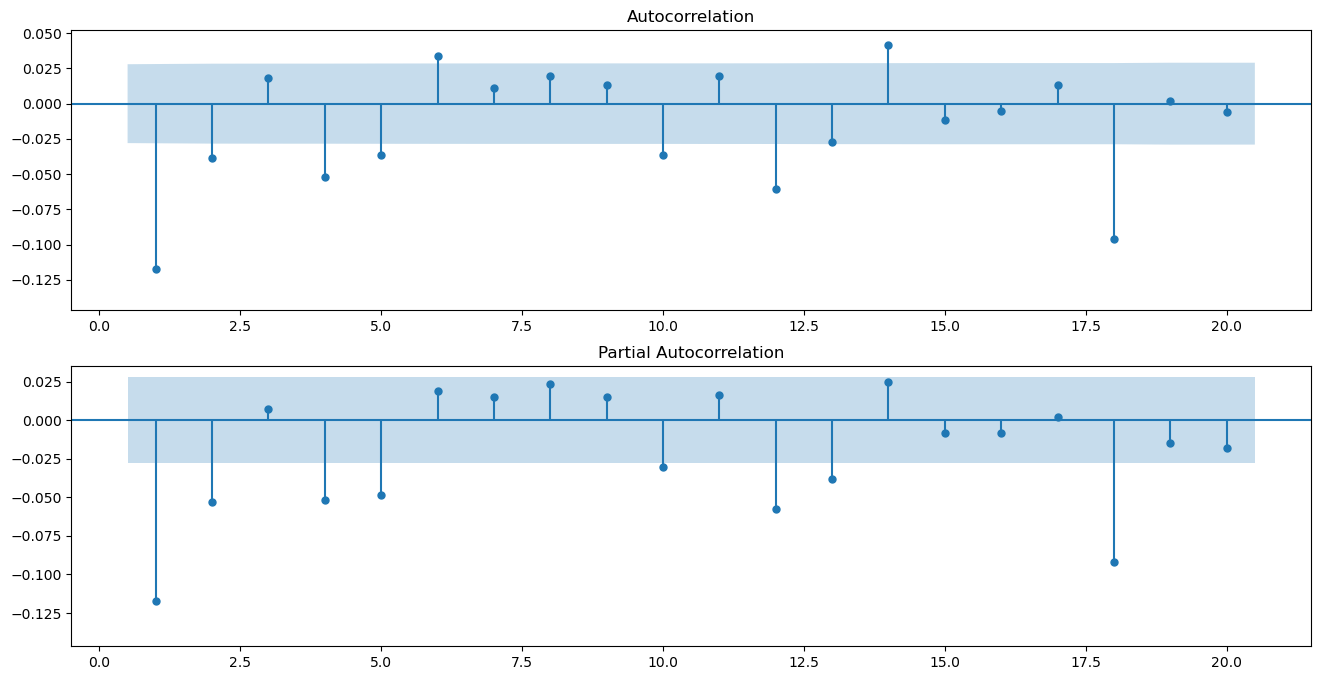

In [42]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (16,8))

# Make coffee basis ACF plot
plot_acf(df_diff_train['br_basis'], lags=20, zero=False, auto_ylims=True, ax=ax1)

# Make coffee basis PACF plot
plot_pacf(df_diff_train['br_basis'],lags=20, zero=False, auto_ylims=True,ax=ax2)
plt.show();

ACF and PACF sugest sazonability effect beyong the 12 days period. Both ACF and PACF show correlation for lag 2. So an ARMA(2,2) with sazonability should be investigated starting point for a SARIMA or SARIMAX model.

In [ ]:
# ARIMA model

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
arima_order = []

for p in range(6):
    for q in range(6):
        print(p,q)
        try:
            model = ARIMA(df_train['br_basis'], order=(p, 1, q))
            result = model.fit()
            arima_order.append((p, q, result.aic, result.bic))
        except:
            print(f'p: {p}, q: {q} is a bad model - {e}')
            

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 3
2 4
2 5
3 0
3 1
3 2
3 3


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 4
3 5
4 0
4 1
4 2
4 3


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4 4


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4 5


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 0
5 1
5 2


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 3


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 4


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 5


/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
df_arima = pd.DataFrame(arima_order,columns=['p','q','AIC',"BIC"])

In [ ]:
# Sorting by AIC and printing the first 5 rows
df_arima_aic_sorted = df_arima.sort_values(by='AIC')
print("Top 5 AIC values:")
print(df_arima_aic_sorted.head())

# Sorting by BIC and printing the first 5 rows
df_arima_bic_sorted = df_arima.sort_values(by='BIC')
print("\nTop 5 BIC values:")
print(df_arima_bic_sorted.head())

Top 5 AIC values:
    p  q           AIC           BIC
35  5  5  21506.443563  21577.932884
34  5  4  21507.746778  21572.737070
15  2  3  21508.285105  21547.279280
29  4  5  21510.197206  21575.187498
9   1  3  21511.051070  21543.546216

Top 5 BIC values:
    p  q           AIC           BIC
8   1  2  21512.571696  21538.567812
9   1  3  21511.051070  21543.546216
14  2  2  21511.546480  21544.041626
15  2  3  21508.285105  21547.279280
20  3  2  21511.611466  21550.605642


Our goal is to find the best predictive model, however several of the best AIC models failed to converge. ARIMA(1,1,3) is the only model that appear as the top model for both criteria and converged. Therefore, ARIMA(1,1,3) will be chosen as the base line model.


ARIMA(2,1,3) base model

ARIMA models

In [201]:
stepwise_fit = pm.auto_arima(df_test['br_basis'],
                             trace=True,
                             seasonal=True,
                             suppress_warnings=True,
                            )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6630.040, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6675.487, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6664.879, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6662.675, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6673.489, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6628.037, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6653.611, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6626.041, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6628.036, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6658.728, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6624.055, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6660.677, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6662.881, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6626.050, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [199]:
# Fiting the model in the testing data
base_model = ARIMA(df_test['br_basis'], order=(1, 1, 3))
base_model_fit =base_model.fit()


mae_base = np.mean(np.abs(base_model_fit.resid))
print(f'Base model MAE of testing data: {mae_base}')

Base model MAE of testing data: 1.419698170318787


Comparining ARIMA models

In [178]:
start = df_test.index.to_timestamp()[0]
end = df_test.index.to_timestamp()[-1]
y_test = df_test['br_basis']

In [114]:
# Fiting the model in the testing data
base_model = ARIMA(df_test['br_basis'], order=(1, 1, 3))
base_model_fit =base_model.fit()

In [184]:
base_model_forecast = base_model_fit.predict(start=start, end = end)


mae_base = mean_absolute_error(y_test,base_model_forecast)
rmse_base = np.sqrt(mean_squared_error(y_test,base_model_forecast))
print(f'Base model MAE of testing data: {mae_base}')
print(f'Base model RMSE of testing data: {rmse_base}')

Base model MAE of testing data: 1.419698170318787
Base model RMSE of testing data: 2.028187956650478


In [118]:
# Fiting ARIMA(1,1,1)
arima_111_model = ARIMA(df_test['br_basis'], order=(1, 1, 1))
arima_111_fit = arima_111_model.fit()

In [188]:
arima_111_forecast = arima_111_fit.predict(start=start, end = end)

mae_arima_111 = mean_absolute_error(y_test,arima_111_forecast)
rmse_arima_111 = np.sqrt(mean_squared_error(y_test,arima_111_forecast))
print(f'ARIMA(1,1,1) model MAE of testing data: {mae_arima_111}')
print(f'ARIMA(1,1,1) model RMSE of testing data: {rmse_arima_111}')

ARIMA(1,1,1) model MAE of testing data: 1.419602175735249
ARIMA(1,1,1) model RMSE of testing data: 2.0282140676936824


It is a challenge to model long seasonality into a daily series. The result shows ARIMA(1,1,1) is slightly better than the base model.


Models residual analysis

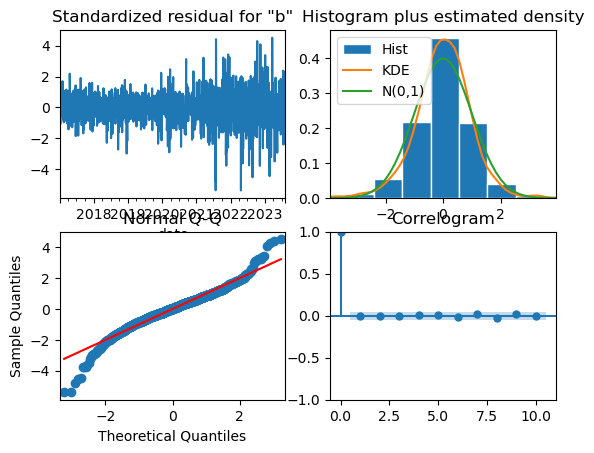

In [ ]:
base_model_fit.plot_diagnostics()
plt.show();

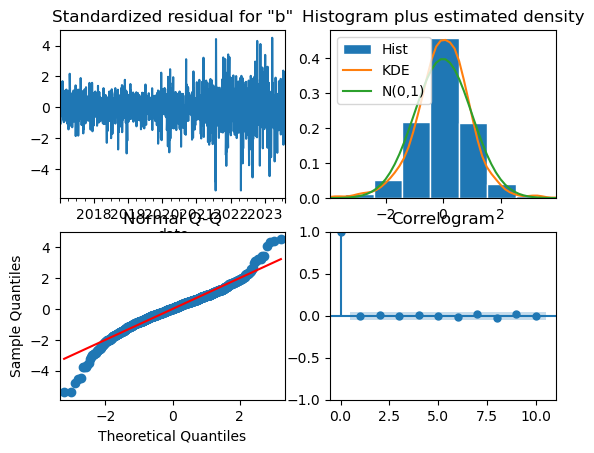

In [ ]:
arima_111_fit.plot_diagnostics()
plt.show();


Models summary

In [ ]:
display(base_model_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               br_basis   No. Observations:                 1604
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -3309.003
Date:                Fri, 01 Dec 2023   AIC                           6628.007
Time:                        08:58:29   BIC                           6654.905
Sample:                    01-03-2017   HQIC                          6637.994
                         - 08-08-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7644      0.065     11.682      0.000       0.636       0.893
ma.L1         -0.8820      0.067    -13.091      0.000      -1.014      -0.750
ma.L2          0.0041      0.028      0.143      0.886      -0.052       0.060
ma.L3         -0.0072      0.027     -0.265      0.791      -0.060       0.046
sigma2         3.6347      0.083     43.573      0.000       3.471       3.798
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               671.30
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.64   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
display(arima_111_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               br_basis   No. Observations:                 1604
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3309.027
Date:                Fri, 01 Dec 2023   AIC                           6624.055
Time:                        08:59:26   BIC                           6640.193
Sample:                    01-03-2017   HQIC                          6630.047
                         - 08-08-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7743      0.037     20.806      0.000       0.701       0.847
ma.L1         -0.8908      0.027    -33.557      0.000      -0.943      -0.839
sigma2         3.6349      0.082     44.480      0.000       3.475       3.795
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               676.45
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
display(sarima_model_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               br_basis   No. Observations:                 1241
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2973.757
Date:                Fri, 01 Dec 2023   AIC                           5955.514
Time:                        09:00:13   BIC                           5976.009
Sample:                    07-03-2018   HQIC                          5963.221
                         - 08-08-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.036     -0.087      0.931      -0.074       0.068
ar.L1          0.8299      0.037     22.644      0.000       0.758       0.902
ma.L1         -0.9194      0.025    -36.696      0.000      -0.969      -0.870
sigma2         7.0605      0.210     33.649      0.000       6.649       7.472
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               159.01
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

XGBoost Model

In [43]:
# Building the train test data

y_train = df_train['br_basis'].copy()
X_train = df_train.drop(['br_basis'],axis=1)

y_test = df_test['br_basis'].copy()
X_test = df_test.drop(['br_basis'],axis=1)

In [44]:
# XGBoost model fine tunning

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae')

parameters = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12],
    'gamma': [0.005, 0.01],
    'random_state': [42],
    
}


clf = GridSearchCV(model, parameters, cv=3, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[0]	validation_0-mae:5.94742
[1]	validation_0-mae:5.91698
[2]	validation_0-mae:5.88695
[3]	validation_0-mae:5.85739
[4]	validation_0-mae:5.82885
[5]	validation_0-mae:5.80045
[6]	validation_0-mae:5.77257
[7]	validation_0-mae:5.74494
[8]	validation_0-mae:5.71780
[9]	validation_0-mae:5.69099
[10]	validation_0-mae:5.66442
[11]	validation_0-mae:5.63885
[12]	validation_0-mae:5.61399
[13]	validation_0-mae:5.58938
[14]	validation_0-mae:5.56537
[15]	validation_0-mae:5.54224
[16]	validation_0-mae:5.51940
[17]	validation_0-mae:5.49724
[18]	validation_0-mae:5.47562
[19]	validation_0-mae:5.45451
[20]	validation_0-mae:5.43390
[21]	validation_0-mae:5.41371
[22]	validation_0-mae:5.39429
[23]	validation_0-mae:5.37828
[24]	validation_0-mae:5.36268
[25]	validation_0-mae:5.34481
[26]	validation_0-mae:5.33045
[27]	validation_0-mae:5.31690
[28]	validation_0-mae:5.30098
[29]	validation_0-mae:5.28810
[30]	validation_0-mae:5.27562
[31]	validation_0-mae:5.26400
[32]	validation_0-mae:5.25007
[33]	validation_0-ma

In [45]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.005, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

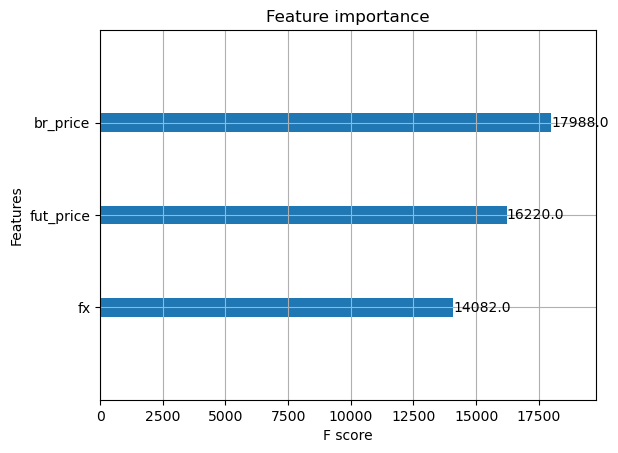

In [48]:
plot_importance(model);

The XGBoost model identifies the Brazilian coffee spot price, future coffee price, and the USD/BRL exchange rate as important features for predicting the basis, in that order.

In [132]:
y_pred = model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred)  )
print(f'XGBoost model MAE of testing data: {mae_xgb:.2f}')
print(f'XGBoost model RMSE of testing data: {rmse_xgb:.2f}')

XGBoost model MAE of testing data: 4.54
XGBoost model RMSE of testing data: 7.07


Prophet model

In [69]:
# Preparing the data set for Prophet modeling

df_train_prophet = df_train.copy()
df_train_prophet.reset_index(inplace=True)

df_train_prophet = df_train_prophet[['date','br_basis']]

df_train_prophet.columns = ['ds','y']

df_train_prophet['ds'] = df_train_prophet['ds'].astype('datetime64[ns]')

df_train_prophet.head()

ds          y
0 1996-09-03 -36.077751
1 1996-09-04 -35.416748
2 1996-09-05 -34.618095
3 1996-09-06 -36.920491
4 1996-09-09 -35.478200

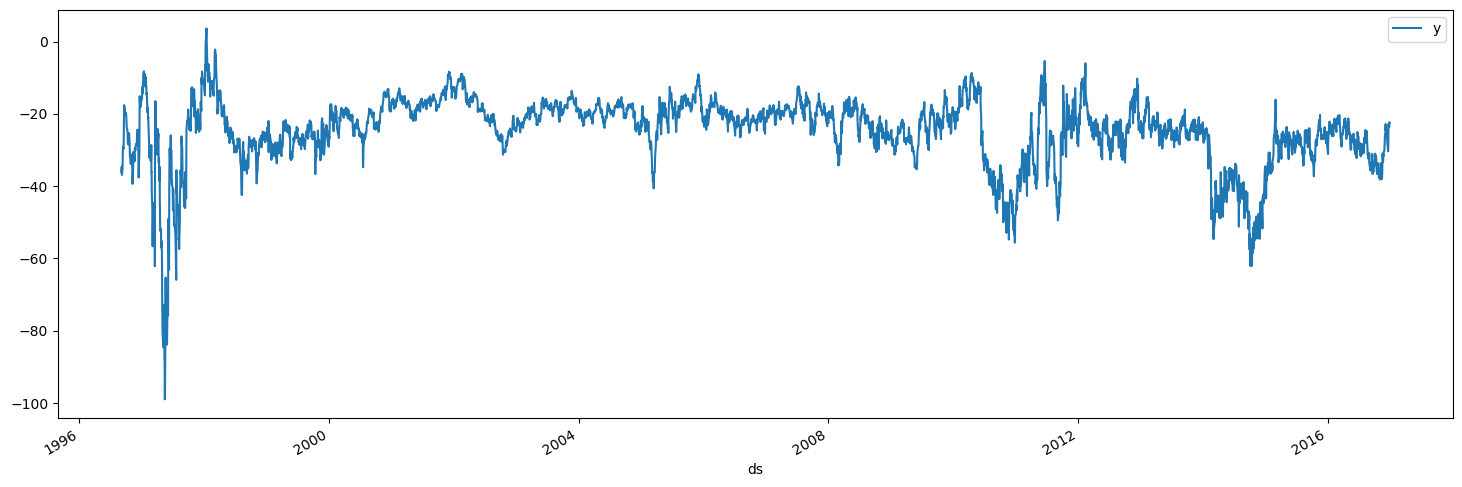

In [70]:
# Plot dataset
df_train_prophet.plot(x='ds',y='y',figsize = (18,6));

This the Brasilian coffee basis training data.

In [71]:
prophet_model = Prophet()
prophet_model.fit(df_train_prophet)

20:46:22 - cmdstanpy - INFO - Chain [1] start processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# Forecasting the test range

n = len(df_test)

future = prophet_model.make_future_dataframe(periods=n)
prophet_forecast = prophet_model.predict(future)

In [85]:
prophet_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          6515 non-null   datetime64[ns]
 1   trend                       6515 non-null   float64       
 2   yhat_lower                  6515 non-null   float64       
 3   yhat_upper                  6515 non-null   float64       
 4   trend_lower                 6515 non-null   float64       
 5   trend_upper                 6515 non-null   float64       
 6   additive_terms              6515 non-null   float64       
 7   additive_terms_lower        6515 non-null   float64       
 8   additive_terms_upper        6515 non-null   float64       
 9   weekly                      6515 non-null   float64       
 10  weekly_lower                6515 non-null   float64       
 11  weekly_upper                6515 non-null   float64     

The Prophet model identifies and decomposes the Basis series into trend and seasonality components. It also recognizes both weekly and yearly seasonality patterns.

In [108]:
# Visualization of prophet model predictions

plot_plotly(prophet_model, prophet_forecast)

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [109]:
# Visualization of prophet model predictions

plot_components_plotly(prophet_model, prophet_forecast)

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/marciobernardo/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

In [134]:
# calculating Prophet model MAE

pro_pred = prophet_forecast['yhat'][-n:]

mae_prophet = mean_absolute_error(y_test, pro_pred) 
rmse_prophet = np.sqrt(mean_squared_error(y_test, pro_pred))
print(f'Prophet model MAE of testing data: {mae_prophet:.2f}')
print(f'Prophet model RMSE of testing data: {rmse_prophet:.2f}')

Prophet model MAE of testing data: 10.10
Prophet model RMSE of testing data: 11.64


Evaluating the different models

In [197]:
# Comparing all models MAE

mae_table = pd.DataFrame({'Base model': [mae_base,rmse_base], 
                          'ARIMA_111': [mae_arima_111,rmse_arima_111], 
                          'XGBoost': [mae_xgb,rmse_xgb], 
                          'Prophet': [mae_prophet,rmse_prophet]},
                         index = ['MAE','RMSE'])


display(mae_table)

Base model  ARIMA_111   XGBoost    Prophet
MAE     1.419698   1.419602  4.544749  10.098708
RMSE    2.028188   2.028214  7.071423  11.639217

The ARIMA(1,1,1) model demonstrates the best performance with the lowest MAE and RMSE scores, indicating its effectiveness in capturing the underlying patterns in the data. XGBoost also exhibits competitive scores, showcasing its predictive capabilities. Notably, the Prophet model, designed to handle seasonality, shows higher error metrics compared to the other models, suggesting potential challenges in accurately capturing the complex temporal patterns of the Basis series.

Visual Inspection of the model forecasts

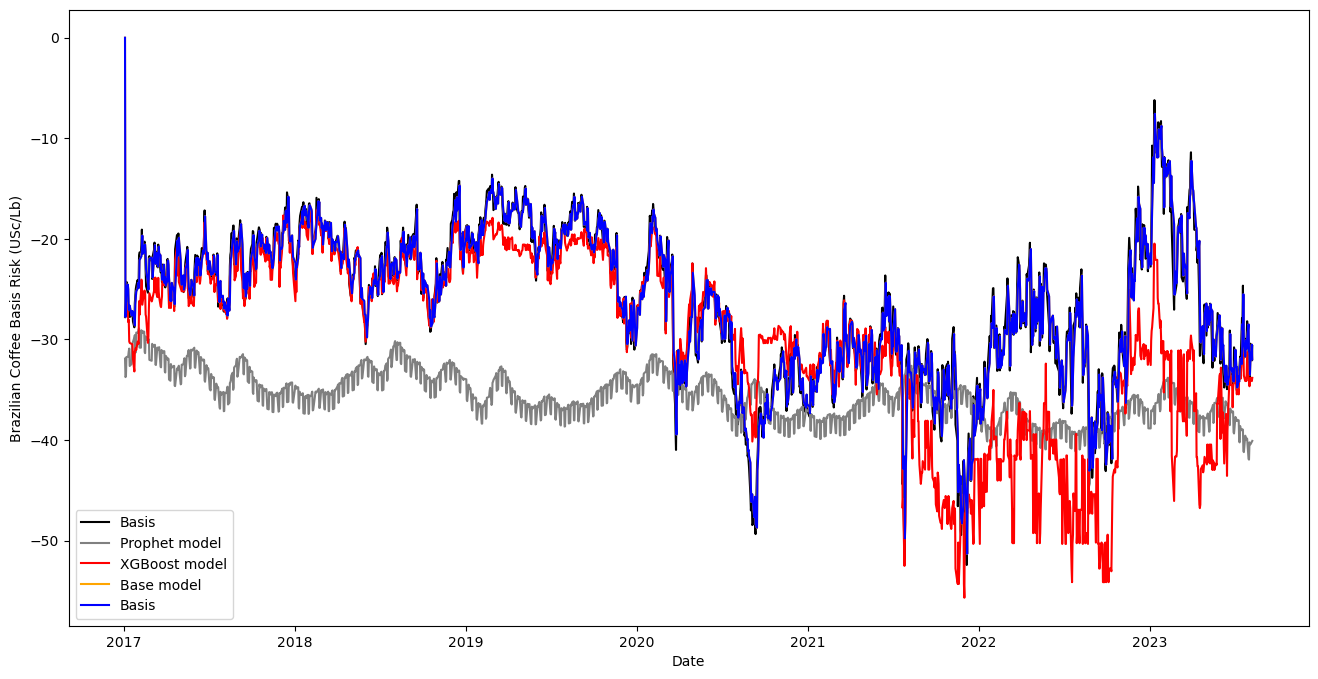

In [196]:
plt.figure(figsize=(16,8))

plt.plot(df_test.index.to_timestamp(),
         df_test['br_basis'],
         color = 'black',
         label='Basis')

plt.plot(df_test.index.to_timestamp(),
         pro_pred,
         color = 'grey',
         label='Prophet model')

plt.plot(df_test.index.to_timestamp(),
         y_pred,
         color = 'red',
         label='XGBoost model')

plt.plot(df_test.index.to_timestamp(),
         base_model_forecast,
         color = 'orange',
         label='Base model')

plt.plot(df_test.index.to_timestamp(),
         arima_111_forecast,
         color = 'blue',
         label='Basis')



plt.xlabel('Date')
plt.ylabel('Brazilian Coffee Basis Risk (USc/Lb)')
plt.legend()
plt.show();

Conclusion

In conclusion, the ARIMA(1,1,1) model emerged as the most effective among the studied models, showcasing its robust performance in modeling the Brazilian basis risk time series. This model not only excelled in short-term predictions but also demonstrated competence in long-term forecasting. On the other hand, XGBoost proved to be a valuable tool, particularly well-suited for short to mid-term forecasts, offering reliable insights into the dynamics of the basis risk. Overall, both the ARIMA and XGBoost models present strong capabilities in capturing and predicting the complexities of the Brazilian basis risk, making them practical and valuable tools for practitioners, hedgers, and investors. The accurate predictions generated by these models can serve as valuable inputs for informed decision-making in real-world applications.